# New implementation of simulation for iterative estimation of Beta-distribution parameters that fit the distribution of stationary activity

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.simulation import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

In [2]:
coupling_weights?

Signature: coupling_weights(N, K, lambda_, seed)
Docstring:
Generate coupling weights.

Parameters
----------
N : int
    Number of neurons.
K : int
    Avg. number of connections per neuron
lambda_ : float
    total incomming synaptic weight per neuron (lambda_ = sum_j w_ij)
seed : int
    Random seed.   

Returns
-------
w : sparse matrix of shape (N,N)
    Connectivity matrix.
File:      ~/git/projects/sahel_finite-observation-dynamic-range/0_update/src/simulation.py
Type:      function

In [3]:
print('quick test of API:')
N=20
K=5
lambda_=1
seed=1000

w = coupling_weights(N, K, lambda_, seed)
# lambda = sum_j w_ij
print(np.sum(w, axis=1).flatten())
# thus w * 1 = lambda * 1
print(w.dot(np.ones(N)))

quick test of API:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
external_spiking_probability?

Signature: external_spiking_probability(N, mu, h_, seed, dt=1)
Docstring:
Generate external spiking probability vector.

Parameters
----------
N : int
    Number of neurons.
mu : float
    Fraction of neurons that receive external input
h_ : float
    External input rate that selected neurons receive
seed : int
    Random seed.
dt : float
    Time step.

Returns
-------
h : array of shape (2,mu*N)
    External spiking probability.
File:      ~/git/projects/sahel_finite-observation-dynamic-range/0_update/src/simulation.py
Type:      function

In [5]:
print('quick test of API:')
N=20
mu=0.2
h=2
seed=1000
p_h = external_spiking_probability(N, mu, h, seed)
print(p_h)

quick test of API:
(array([ 5, 18,  3,  6]), array([0.86466472, 0.86466472, 0.86466472, 0.86466472]))


### Verify with analytic calculation of mean activity

In [6]:
N=int(1e4)
K=100
list_h=np.logspace(-5,1,6)
mu=0.2
dt=1
# prepare for reset in loop
p_h = external_spiking_probability(N, mu, 0, seed=1234, dt=1)
# recurrent coupling fixed
lambda_ = 0.9
w = coupling_weights(N, K, lambda_, seed=1234)

# run self-build simulations
T = 10000
T_burn = 1000
list_a = np.zeros_like(list_h)
rng = np.random.default_rng(1234)
for (i,h) in tqdm(enumerate(list_h)):
    p_h = external_spiking_probability(N, mu, h, seed=1234, dt=1)
    activity = np.zeros(T)
    x = np.zeros(N)
    for t in range(T):
        x = step(x, w, p_h, rng)
        activity[t] = np.mean(x)
    list_a[i] = np.mean(activity[T_burn:])

6it [01:12, 12.13s/it]


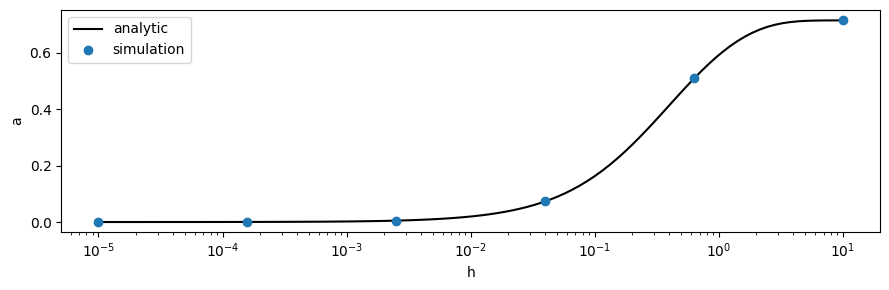

In [7]:
def a(h, mu, lambda_, dt=1):
    return mu*(1-np.exp(-h*dt))/(1-lambda_*(1-mu)-lambda_*mu*np.exp(-h*dt))

list_h_ana = np.logspace(-5,1,100)
list_a_ana = [a(h, mu, lambda_) for h in list_h_ana]

plt.figure(figsize=(9,3))
plt.plot(list_h_ana, list_a_ana, '-', label='analytic', color='black')
plt.plot(list_h, list_a, 'o', label='simulation')
plt.xscale('log')
plt.xlabel('h')
plt.ylabel('a')
plt.legend()
plt.tight_layout()

### Fitting beta distribution


In [8]:
def fit_beta_distribution(data, delta, seed=1234):
    np.random.seed(seed)
    # add very small jitter to avoid problems with delta distributions
    data = data + np.random.randn(len(data))*delta/7
    # IMPORTANT: The beta distribution is defined on the interval [0,1] but because of the discretization we need to shift the support by delta and scale it by 1+2*delta
    a,b,loc,scale = stats.beta.fit(data, floc=-delta, fscale=1+2*delta) 
    return a,b,loc,scale

In [9]:
N=int(1e4)
K=100
mu=0.2
lambda_ = 0.0
h_ = 10
seed = 1000
p_h = external_spiking_probability(N, mu, h_, seed)
print(type(p_h))
w = coupling_weights(N, K, lambda_, seed)
print(type(w))

T = int(1e4)
activity = np.zeros(T, dtype=np.float64)
rng = np.random.RandomState(seed)
x = np.random.randint(0,2,N)
for t in tqdm(range(T)):
    x = step(x, w, p_h, rng)
    activity[t] = np.sum(x)

<class 'tuple'>
<class 'scipy.sparse._csr.csr_matrix'>


100%|██████████| 10000/10000 [00:11<00:00, 883.14it/s]


[0.000e+00 1.000e-04 2.000e-04 ... 9.998e-01 9.999e-01 1.000e+00]
0.0001 0.0001
1.0
2.73e+07,1.09e+08,-0.0001,1.0002


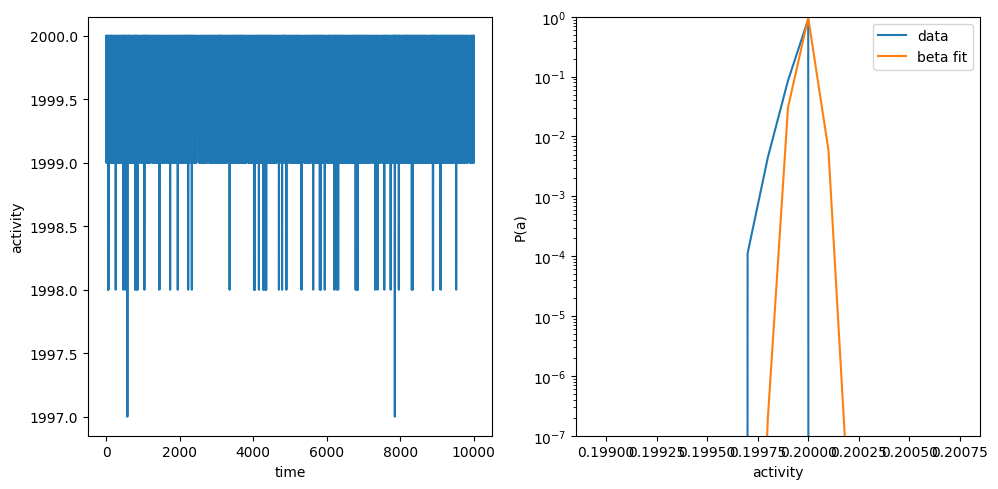

In [10]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(activity, label='data')
axes[0].set_xlabel('time') 
axes[0].set_ylabel('activity')

delta = 1/N
support = np.linspace(0,1,N+1)
print(support)
print(delta, support[1]-support[0])
data = activity[1000:]/N
# histogram needs bin edges but we work with bin centers, hence need to shift support
pmf_data = np.histogram(data, bins=np.append(support,1+delta)-delta/2, density=False)[0]/len(data)
print(np.sum(pmf_data))
axes[1].plot(support, pmf_data, label='data')
a,b,loc,scale = fit_beta_distribution(data, delta, seed)
print(f'{a:.2e},{b:.2e},{loc},{scale}')
pmf_beta = stats.beta.pdf(support, a,b, loc=loc, scale=scale)
pmf_beta = pmf_beta/np.sum(pmf_beta)
axes[1].plot(support, pmf_beta, label='beta fit')
axes[1].set_xlabel('activity')
axes[1].set_ylabel('P(a)')
axes[1].set_yscale('log')
axes[1].set_ylim([1e-7,1])
axes[1].legend()
range_data = support[np.nonzero(pmf_data)]
if len(range_data) > 10:
    axes[1].set_xlim([range_data[0],range_data[-1]])
else:
    axes[1].set_xlim([np.median(range_data)-10*delta,np.median(range_data)+10*delta])
plt.tight_layout()

### Prepare automatic simulations
For simplicity, the window here is implemented as an exponential moving average such that $o_T = 1/T \sum_t o_t$ is replaced by $o_T = \sum_t' o_t' e^{(t-t')/T}$

In [11]:
simulation?

Signature:
simulation(
    params,
    steps={'burn': 'self', 'equil': 'self', 'record': 'self'},
    windows=array([1.e-06, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
)
Docstring:
run simulation and return sliding window estimates

Parameters
----------
params : dict
    dictionary with parameters that needs to include
    - N : int
        number of neurons
    - K : int
        number of incoming connections per neuron
    - lambda : float
        coupling strength
    - mu : float
        fraction of neurons that receive external input
    - h : float
        external input
    - seed : int
        random seed
    - dt : float    
        time step
steps : dict
    dictionary with steps to run (default is self-consistently determined)
windows : array
    array with windows to use for sliding window estimates

Returns
-------
windows : array
    array with windows used for sliding window estimates
samples : array
    array with sliding window estimates of length steps['record']
File:

Example for small input and large fluctuations

In [8]:
params = {
    'N': int(1e4),
    'K': 100,
    'lambda': 0.9,
    'mu': 0.2,
    'h': 1e-5,
    'seed': 1000,
}
example1 = simulation(params, windows=np.array([1.0,10.0,100.0]))

[0.63212056 0.09516258 0.00995017]
# COMMENT: burn-in steps self-consistently set to 2.84e+02 = max(30 * tau, window_max) with tau = -dt / ln(lambda) = 9.49e+00 and window_max=1.00e+02
# COMMENT: equilibration steps self-consistently set to 3.00e+02 = 3 * window_max = 1.00e+02
# COMMENT: recording steps self-consistently set to 1.00e+04 = max(1000 * tau, 100*window_max) with tau = -dt / ln(lambda) = 9.49e+00 and window_max=1.00e+02
initialize with random spiking condition


recording: 100%|██████████| 10000/10000 [00:16<00:00, 621.46it/s]


1e-06	6.36e-01,1.81e+03,-0.0001,1.0002, 0.0003521275847233866, 0.00025134
1.0	6.41e-01,1.82e+03,-0.0001,1.0002, 0.000352122779471825, 0.0002513399999999993
10.0	6.74e-01,1.91e+03,-0.0001,1.0002, 0.0003520668899226377, 0.0002513360966380317
100.0	8.45e-01,2.41e+03,-0.0001,1.0002, 0.00035110991067817827, 0.0002506321857410017
1000.0	1.50e+00,4.29e+03,-0.0001,1.0002, 0.0003499685502305176, 0.00024996037889060994
10000.0	5.67e+00,1.83e+04,-0.0001,1.0002, 0.00030969453922647256, 0.00020980162514712546


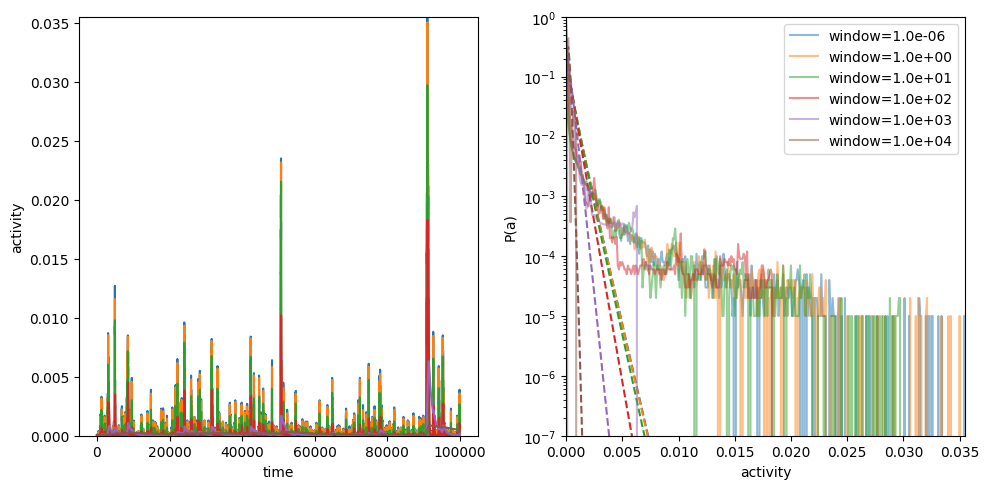

In [13]:
result = example1
windows = result['windows']

# plot distribution of estimates for different windows in one plot
fig, axes = plt.subplots(1,2, figsize=(10,5))
# plot samples over time
axes[0].set_xlabel('time')
axes[0].set_ylabel('activity')

# plot distribution of estimates for different windows in one plot
range_data = [1,0]
for (i,window) in enumerate(windows):
    data = result[f'samples'][window]
    axes[0].plot(data)
    # spacing should depend on window size, larger windows means smaller discretization (but then this also requires more samples ...)
    delta = 1/N
    support = np.linspace(0,1,N+1)
    pmf_data = np.histogram(data, bins=np.append(support,1+delta)-delta/2, density=False)[0]/len(data)
    ref = axes[1].plot(support, pmf_data, label=f'window={windows[i]:.1e}', alpha=0.5)
    # fit beta distribution
    a,b,loc,scale = fit_beta_distribution(data, delta, seed)
    print(f'{window}\t{a:.2e},{b:.2e},{loc},{scale}, {a/(a+b)}, {np.mean(data)}')
    pmf_beta = stats.beta.pdf(support, a,b, loc=loc, scale=scale)
    pmf_beta = pmf_beta/np.sum(pmf_beta)
    axes[1].plot(support,pmf_beta, color=ref[0].get_color(), linestyle='--')

    range_data[0] = min(range_data[0], support[np.nonzero(pmf_data)][0])
    range_data[1] = max(range_data[1], support[np.nonzero(pmf_data)][-1])
axes[1].set_xlabel('activity')
axes[1].set_ylabel('P(a)')
# set xrange to range of data
axes[1].set_yscale('log')
axes[1].set_ylim([1e-7,1])
axes[1].set_xlim(range_data)
axes[0].set_ylim(range_data)
axes[1].legend()
plt.tight_layout()


Example for medium input and small fluctuations

In [14]:
params = {
    'N': int(1e4),
    'K': 100,
    'lambda': 0.9,
    'mu': 0.2,
    'h': 1e-3,
    'seed': 1000,
    'dt': 1,
}
example2 = simulation(params)

[1.00000000e+00 6.32120559e-01 9.51625820e-02 9.95016625e-03
 9.99500167e-04 9.99950002e-05]
# COMMENT: burn-in steps self-consistently set to 9.40e+01 = 50 * tau with tau = -dt / ln(lambda) = 9.49e+00
# COMMENT: equilibration steps self-consistently set to 1.00e+04 = window_max = 1.00e+04
# COMMENT: recording steps self-consistently set to 1.00e+05 = max(1000 * tau, 10*window_max) with tau = -dt / ln(lambda) = 9.49e+00 and window_max=1.00e+04
initialize with random spiking condition


recording: 100%|██████████| 100000/100000 [02:10<00:00, 768.65it/s]


In [15]:
result['samples'][1e-06]

array([0., 0., 0., ..., 0., 0., 0.])

1e-06	4.12e+00,1.98e+03,-0.0001,1.0002, 0.002071711332884077, 0.0019721849999999996
1.0	4.56e+00,2.20e+03,-0.0001,1.0002, 0.0020717218809977607, 0.001972186286116717
10.0	9.12e+00,4.39e+03,-0.0001,1.0002, 0.0020717017060715675, 0.001972157439335033
100.0	5.24e+01,2.52e+04,-0.0001,1.0002, 0.002071630492066426, 0.00197209475366406
1000.0	5.22e+02,2.51e+05,-0.0001,1.0002, 0.0020732960653725343, 0.0019737611301622955
10000.0	1.01e+03,4.81e+05,-0.0001,1.0002, 0.0020993620685933146, 0.001999832284900933


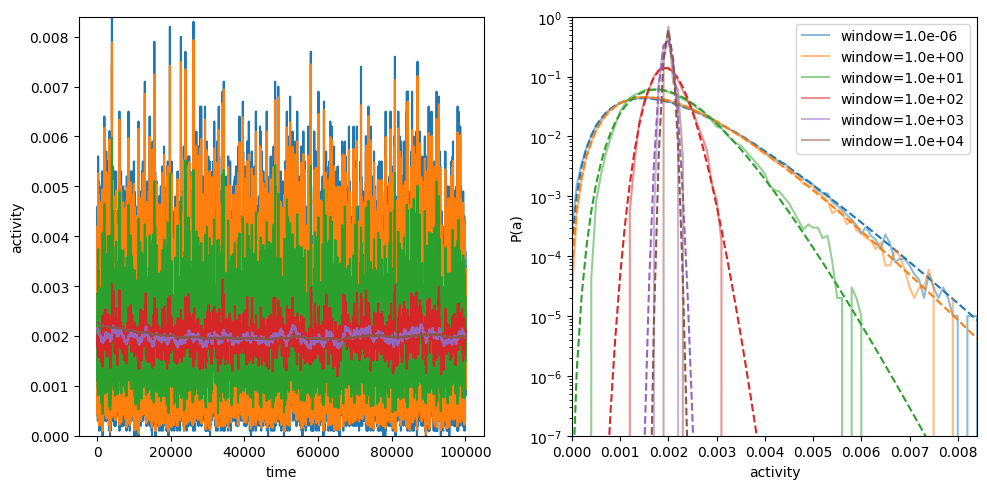

In [16]:
result = example2
windows = result['windows']

# plot distribution of estimates for different windows in one plot
fig, axes = plt.subplots(1,2, figsize=(10,5))
# plot samples over time
axes[0].set_xlabel('time')
axes[0].set_ylabel('activity')

# plot distribution of estimates for different windows in one plot
range_data = [1,0]
for (i,window) in enumerate(windows):
    data = result['samples'][window]
    #timeseries
    axes[0].plot(data)
    # distributions
    delta = 1/N
    support = np.linspace(0,1,N+1)
    pmf_data = np.histogram(data, bins=np.append(support,1+delta)-delta/2, density=False)[0]/len(data)
    ref = axes[1].plot(support, pmf_data, label=f'window={windows[i]:.1e}', alpha=0.5)
    # fit beta distribution
    a,b,loc,scale = fit_beta_distribution(data, delta, seed)
    print(f'{window}\t{a:.2e},{b:.2e},{loc},{scale}, {a/(a+b)}, {np.mean(data)}')
    pmf_beta = stats.beta.pdf(support, a,b, loc=loc, scale=scale)
    pmf_beta = pmf_beta/np.sum(pmf_beta)
    axes[1].plot(support,pmf_beta, color=ref[0].get_color(), linestyle='--')

    range_data[0] = min(range_data[0], support[np.nonzero(pmf_data)][0])
    range_data[1] = max(range_data[1], support[np.nonzero(pmf_data)][-1])
axes[1].set_xlabel('activity')
axes[1].set_ylabel('P(a)')
# set xrange to range of data
axes[1].set_yscale('log')
axes[1].set_ylim([1e-7,1])
axes[1].set_xlim(range_data)
axes[0].set_ylim(range_data)
axes[1].legend()
plt.tight_layout()


### Write to file

In [17]:
save_simulation?

Signature: save_simulation(result, path='./dat/')
Docstring:
Save simulation results to file.

Parameters
----------
result : dict
    Dictionary with simulation parameters and results.
path : str, optional
    Path to save file to. Default is '.dat/'.

Returns
-------
filename : str
    Name of the saved file.
File:      ~/git/projects/sahel_finite-observation-dynamic-range/0_update/src/simulation.py
Type:      function

In [21]:
save_simulation(example1)

In [19]:
# load hdf5 file
import h5py
filename = './dat/N=10000_K=100/1-lambda=1.00e-01/simulation_mu=0.20_h=1.00e-03_seed=1000.h5'
with h5py.File(filename, 'r') as file:
    windows = file['windows'][:]
    print(f'windows: {windows}')
    samples = file[f'samples/{windows[1]}'][:]
    print(f'sample window[1]: {samples}')
    print(file[f'params'].keys())
    

windows: [1.e-06 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
sample window[1]: [0.00194991 0.00217121 0.00225262 ... 0.00208026 0.00183989 0.00181468]
<KeysViewHDF5 ['K', 'N', 'dt', 'h', 'lambda', 'mu', 'seed']>


In [2]:
for h in np.logspace(-4,1,11):
    header=\
    f"""\
-----------------------------
           h={h}
-----------------------------\
    """
    print(header)
    params = {
        'N': int(1e4),
        'K': 100,
        'lambda': 0.9999,
        'mu': 0.2,
        'h': h,
        'seed': 1000,
        'dt': 1,
    }
    result = simulation(params)
    save_simulation(result)

-----------------------------
           h=0.0001
-----------------------------    
[1.00000000e+00 6.32120559e-01 9.51625820e-02 9.95016625e-03
 9.99500167e-04 9.99950002e-05]
# COMMENT: burn-in steps self-consistently set to 2.84e+02 = 50 * tau with tau = -dt / ln(lambda) = 9.49e+00
# COMMENT: equilibration steps self-consistently set to 3.00e+04 = window_max = 1.00e+04
# COMMENT: recording steps self-consistently set to 1.00e+06 = max(1000 * tau, 10*window_max) with tau = -dt / ln(lambda) = 9.49e+00 and window_max=1.00e+04
initialize with random spiking condition


recording:  24%|██▍       | 244657/1000000 [04:30<13:56, 903.13it/s]


KeyboardInterrupt: 